In [1]:
import os
import pickle
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller

from IPython import display

## **Load DataFrame**

In [2]:
df = pd.read_csv('data/venezia.csv')
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
df.sort_values(by='datetime', inplace=True, ignore_index=True)
df.head()

,datetime,level
0,1983-01-01 01:00:00,44.0
1,1983-01-01 02:00:00,35.0
2,1983-01-01 03:00:00,23.0
3,1983-01-01 04:00:00,10.0
4,1983-01-01 05:00:00,1.0


## **Analying Time Increments**

In [3]:
values = df.datetime.values.astype('int64') // 10**9
ranges = values[1:]-values[:-1]
vals, counts = np.unique(ranges, return_counts=True)
print("TIME INCREMENTS")
for val, count in zip(vals, counts):
    print(f"{val} - {count}")

TIME INCREMENTS
0 - 5
3600 - 289261
7200 - 5


In [4]:
bad_indecies = [[x, x+1] for x in np.where(ranges!=3600)[0]]
print("BAD INDECIES")
for [idx1, idx2] in bad_indecies:
    print(f"INCREMENT: {values[idx2] - values[idx1]} FROM {idx1}: {df.level.values[idx1]} TO {idx2}: {df.level.values[idx1]}")

BAD INDECIES
INCREMENT: 0 FROM 140255: 57.0 TO 140256: 57.0
INCREMENT: 7200 FROM 148991: 6.0 TO 148992: 6.0
INCREMENT: 0 FROM 198815: 54.0 TO 198816: 54.0
INCREMENT: 7200 FROM 198839: 51.0 TO 198840: 51.0
INCREMENT: 0 FROM 219143: 2.0 TO 219144: 2.0
INCREMENT: 7200 FROM 227903: 19.0 TO 227904: 19.0
INCREMENT: 0 FROM 242639: 37.0 TO 242640: 37.0
INCREMENT: 7200 FROM 242663: 56.0 TO 242664: 56.0
INCREMENT: 0 FROM 251399: -1.0 TO 251400: -1.0
INCREMENT: 7200 FROM 251423: 8.0 TO 251424: 8.0


## **Clean Zero Increments**

In [5]:
df = df.drop(axis=0, index=[x[0] for x in bad_indecies if values[x[1]] - values[x[0]] == 0])
df.head()

,datetime,level
0,1983-01-01 01:00:00,44.0
1,1983-01-01 02:00:00,35.0
2,1983-01-01 03:00:00,23.0
3,1983-01-01 04:00:00,10.0
4,1983-01-01 05:00:00,1.0


In [6]:
values = df.datetime.values.astype('int64') // 10**9
ranges = values[1:]-values[:-1]
vals, counts = np.unique(ranges, return_counts=True)
print("TIME INCREMENTS")
for val, count in zip(vals, counts):
    print(f"{val} - {count}")

TIME INCREMENTS
3600 - 289261
7200 - 5


In [7]:
bad_indecies = [[x, x+1] for x in np.where(ranges!=3600)[0]]
print("BAD INDECIES")
for [idx1, idx2] in bad_indecies:
    print(f"INCREMENT: {values[idx2] - values[idx1]} FROM {idx1}: {df.level.values[idx1]} TO {idx2}: {df.level.values[idx1]}")

BAD INDECIES
INCREMENT: 7200 FROM 148990: 6.0 TO 148991: 6.0
INCREMENT: 7200 FROM 198837: 51.0 TO 198838: 51.0
INCREMENT: 7200 FROM 227900: 19.0 TO 227901: 19.0
INCREMENT: 7200 FROM 242659: 56.0 TO 242660: 56.0
INCREMENT: 7200 FROM 251418: 8.0 TO 251419: 8.0


In [8]:
df = df.set_index('datetime',drop=True)
df.sort_index(inplace=True)
df['set'] = 0
df.head()

,level,set
datetime,,
1983-01-01 01:00:00,44.0,0
1983-01-01 02:00:00,35.0,0
1983-01-01 03:00:00,23.0,0
1983-01-01 04:00:00,10.0,0
1983-01-01 05:00:00,1.0,0


## **Data Functions**

In [11]:
def get_splits(df):
    train_splits = [0.55,0.70,0.85]
    test_size = int(df.shape[0]*0.15)
    splits = []
    for n, t_split in enumerate(train_splits):
        split = int(df.shape[0]*t_split)
        splits.append([split, split+test_size])
    return splits

SPLITS = get_splits(df)
for split in SPLITS:
    print(f"Test Date Range: {df.index.values[split[0]]} to {df.index.values[split[1]]}, Train fraction: {split[0]} / {df.shape[0]} ({split[0] / df.shape[0]}), Test fraction {split[1]-split[0]} / {df.shape[0]} ({(split[1]-split[0]) / df.shape[0]})")

print("\n\n")
df.head()

Test Date Range: 2001-02-24T02:00:00.000000000 to 2006-02-06T01:00:00.000000000, Train fraction: 159096 / 289267 (0.549997061538302), Test fraction 43390 / 289267 (0.14999982714931187)
Test Date Range: 2006-02-06T01:00:00.000000000 to 2011-01-19T01:00:00.000000000, Train fraction: 202486 / 289267 (0.6999968886876139), Test fraction 43390 / 289267 (0.14999982714931187)
Test Date Range: 2011-01-19T01:00:00.000000000 to 2016-01-01T00:00:00.000000000, Train fraction: 245876 / 289267 (0.8499967158369257), Test fraction 43390 / 289267 (0.14999982714931187)





,level,set
datetime,,
1983-01-01 01:00:00,44.0,0
1983-01-01 02:00:00,35.0,0
1983-01-01 03:00:00,23.0,0
1983-01-01 04:00:00,10.0,0
1983-01-01 05:00:00,1.0,0


In [12]:
def dfuller_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
def gaussian(x, value, period, alpha):
    if x - value <= period / 2:
        return np.exp(- (x - value) ** 2 / (2 * alpha))
    else:
        return np.exp(- (x - value - period) ** 2 / ( 2 * alpha))

def sin_radial(x, period):
    return np.sin((np.pi*x)/period)

def cos_radial(x, period):
    return np.cos((np.pi*x)/period)
    
def add_radial_basis_functions(subset, month_alpha=0.8, week_alpha=0.4):
    subset['month'] = [x.month for x in subset.index]
    subset['week'] = [x.week for x in subset.index]
    subset['day'] = [x.timetuple().tm_yday for x in subset.index]
    subset['hour'] = [x.hour for x in subset.index]
    
    subset['covs_week_sin'] = subset.week.apply(sin_radial, period=52)
    subset['covs_week_cos'] = subset.week.apply(cos_radial, period=52)
    
    subset['covs_day_sin'] = subset.day.apply(sin_radial, period=366)
    subset['covs_day_cos'] = subset.day.apply(cos_radial, period=366)
    
    subset['covs_hour_sin'] = subset.hour.apply(sin_radial, period=24)
    subset['covs_hour_cos'] = subset.hour.apply(cos_radial, period=24)
    
    for month in range(1, 13):
        subset[f'covs_rbf_month_{month}'] = subset.month.apply(gaussian, value=month, period=12, alpha=month_alpha)
    subset.drop(['month','week', 'day', 'hour'], axis=1, inplace=True)
    return subset
    
def get_data(df, split, verbose=False):
    [final_train_sample, final_test_sample] = split
    subset = df.copy(deep=True)
    subset.iloc[final_train_sample:final_test_sample, 1] = 1
    
    if(verbose):
        subset.iloc[final_train_sample:final_test_sample].loc[:,'level'].plot(figsize=(16,8))
        plt.title('Pre Normalization')
        plt.show()
        
    normalizer = StandardScaler()
    normalizer.fit(subset.iloc[:final_train_sample].loc[:, ['level']])
    subset['normalized_level'] = normalizer.transform(subset.loc[:,['level']]).reshape((-1,))
    if(verbose):
        subset.iloc[final_train_sample:final_test_sample].loc[:,'normalized_level'].plot(figsize=(16,8))
        plt.title('Post Normalization')
        plt.show()
        
    subset['diff'] = subset['normalized_level'].diff()
    if(verbose):
        subset.iloc[final_train_sample:final_test_sample].loc[:,'diff'].plot(figsize=(16,8))
        plt.title('Diff Post Normalization')
        plt.show()
        
    if(verbose):
        print("Dickey Fuller tests want small p-values")
        print('Dickey Fuller test on level values')
        dfuller_test(subset.iloc[final_train_sample:final_test_sample].loc[:,'level'])
        print("")
        print('Dickey Fuller test on normalized level values')
        dfuller_test(subset.iloc[final_train_sample:final_test_sample].loc[:,'normalized_level'])
        print("")
        print('Dickey Fuller test on normalized diff level values')
        dfuller_test(subset.iloc[final_train_sample:final_test_sample].loc[:,'diff'])
        
    subset = add_radial_basis_functions(subset)
    subset = subset.iloc[:final_test_sample]
    return subset, normalizer

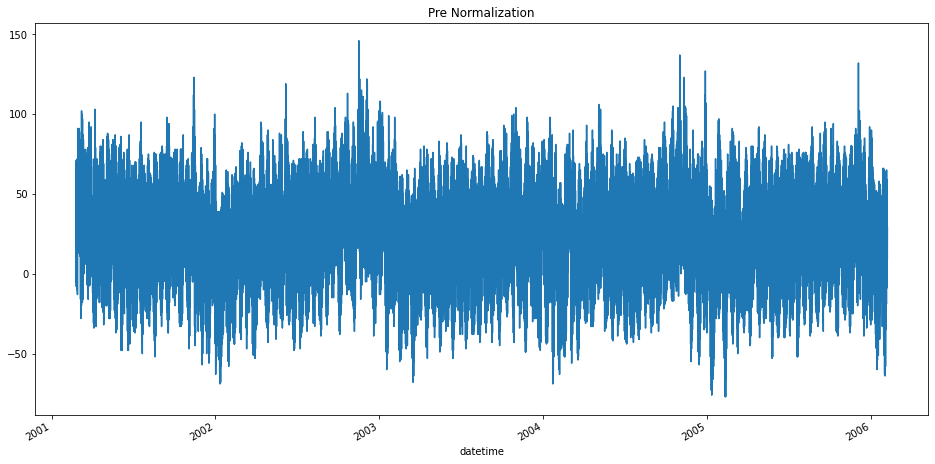

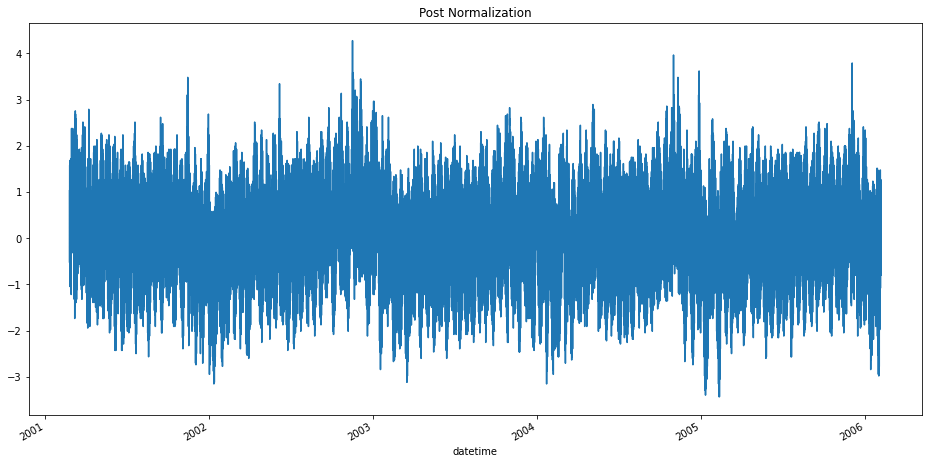

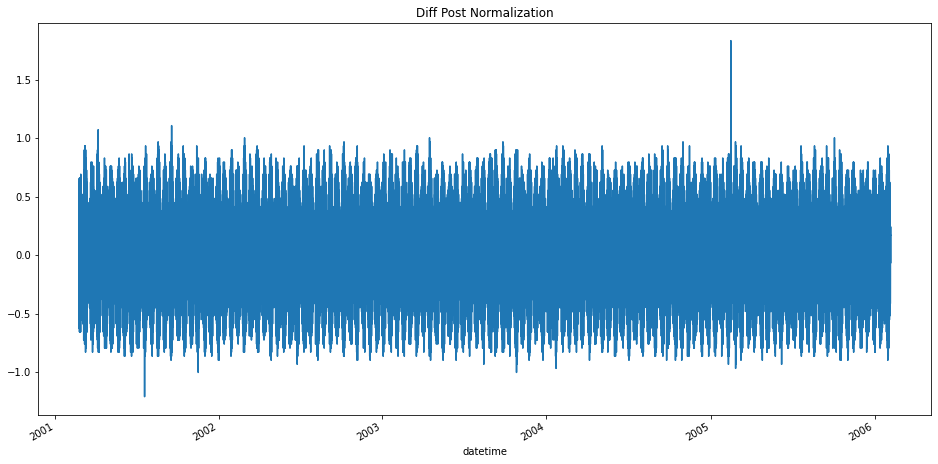

Dickey Fuller tests want small p-values
Dickey Fuller test on level values
ADF Statistic: -10.431224
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized level values
ADF Statistic: -10.431224
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized diff level values
ADF Statistic: -34.105338
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


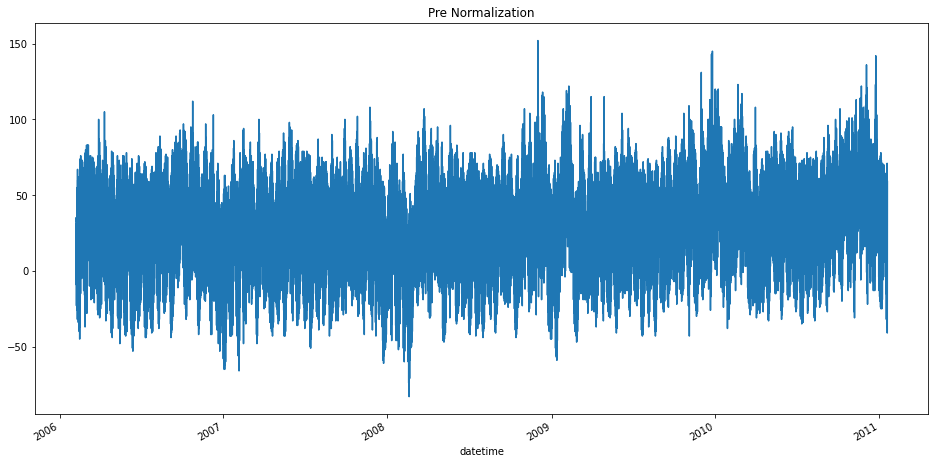

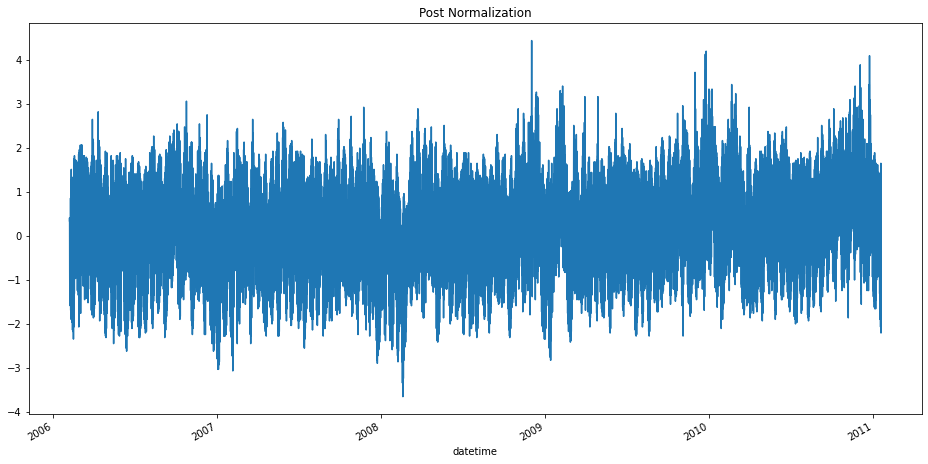

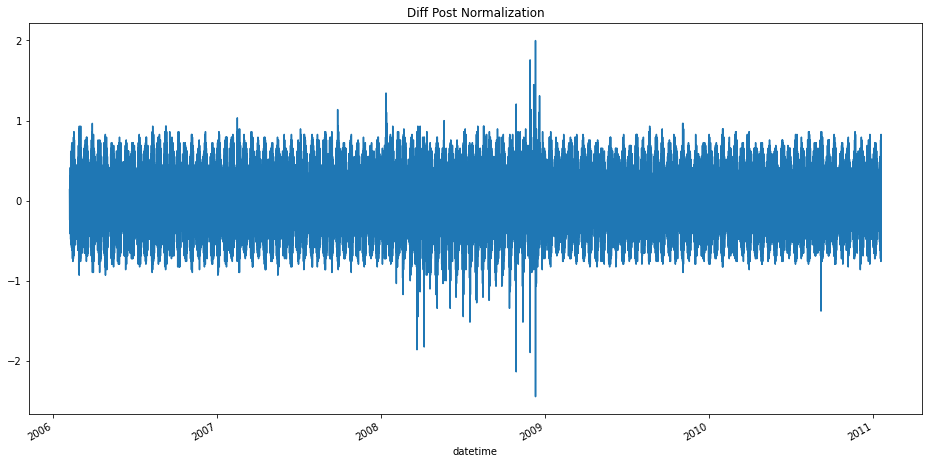

Dickey Fuller tests want small p-values
Dickey Fuller test on level values
ADF Statistic: -9.773674
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized level values
ADF Statistic: -9.773674
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized diff level values
ADF Statistic: -33.883455
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


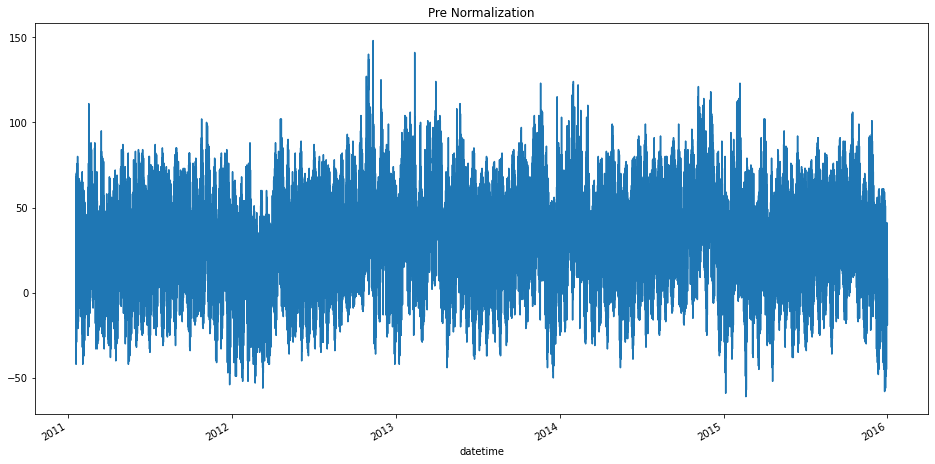

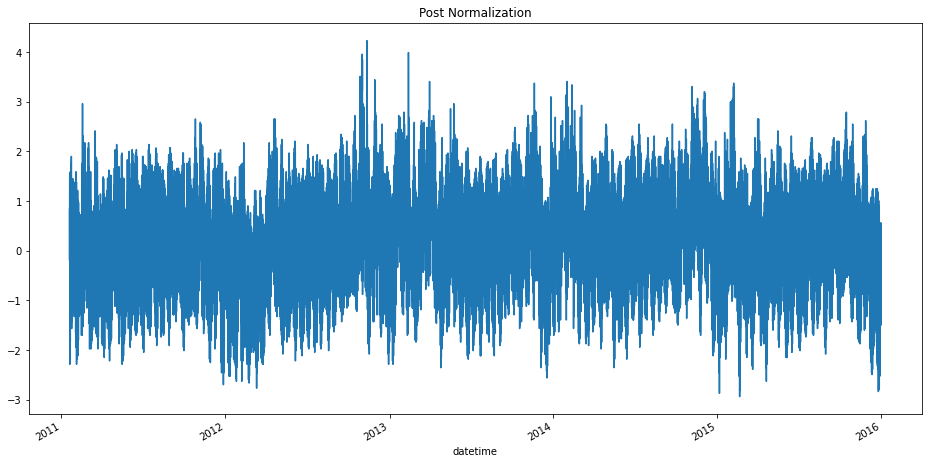

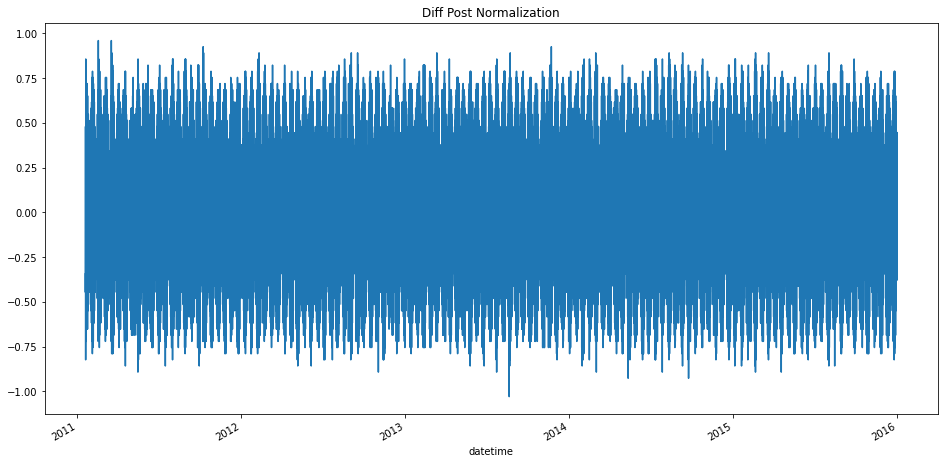

Dickey Fuller tests want small p-values
Dickey Fuller test on level values
ADF Statistic: -10.048564
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized level values
ADF Statistic: -10.048564
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Dickey Fuller test on normalized diff level values
ADF Statistic: -33.162935
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [13]:
for fold, split in enumerate(SPLITS):
    subset, normalizer = get_data(df, split, verbose=True)
    subset.to_csv(f'./data/fold{fold+1}_data_v3.csv')
    with open(f'./data/fold{fold+1}_normalizer_v3.pkl', mode='wb') as f:
        pickle.dump(normalizer, f)